# Demonstrate Heteroscedastic GP

Show the fitting and predictions using heteroscedastic GP. Model is trained to predict the cubic cosine data with linear heteroscedastic noise.

In [16]:
import logging

from dotenv import load_dotenv

import matplotlib.pyplot as plt

import numpy as np

from scipy import stats

import seaborn as sns

import torch


# Force autoreload
%load_ext autoreload
%autoreload 2

# Logger
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)s: %(message)s',
    level=logging.INFO,
    datefmt='%I:%M:%S'
)

# Load dotenv
_ = load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate and plot training data

In [17]:
from gp_sand.generate import PowerCosineHeteroscedastic

gene = PowerCosineHeteroscedastic()

train_x, train_y = gene.training_data(501)
obs_noise = train_y - gene.true_signal(train_x)

x_test = np.linspace(-15, 15)
y_true = gene.true_signal(x_test)
sigma = gene.noise(x_test)**.5

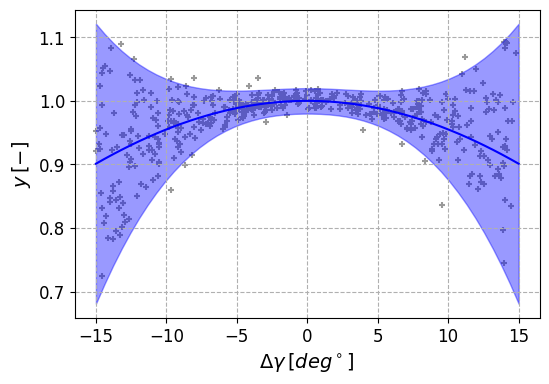

In [18]:
_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')


ax.scatter(
    train_x,
    train_y,
    marker='+',
    s=15,
    c='0.6',
    zorder=1,
    label='observations'
)
ax.plot(x_test, y_true, c='b')
ax.fill_between(
    x_test,
    y_true - 2 * sigma,
    y_true + 2 * sigma,
    alpha=.4,
    color='b'
)

ax.set(
    xlabel=r'$\Delta\gamma\, [deg^\circ]$',
    ylabel=r'$y\, [-]$'
);

/tmp/ipykernel_11571/2121919930.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.log(obs_noise**2),


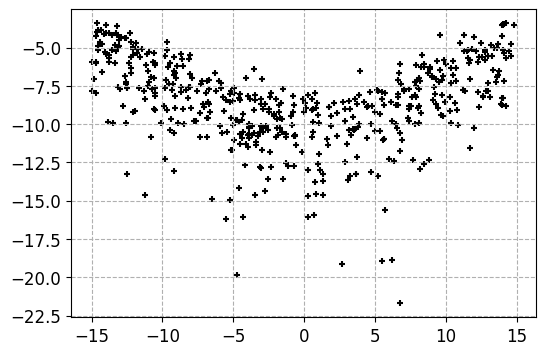

In [19]:
_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

ax.scatter(
    train_x,
    np.log(obs_noise**2),
    marker='+',
    s=15,
    c='k'
)

## Fit model on the log square of the noise

### Setup model

In [20]:
from gpytorch.likelihoods import GaussianLikelihood

from gp_sand.heteroscedastic import NoiseGP

likelihood = GaussianLikelihood()
train_noise = torch.log(obs_noise.pow(2).to(torch.float32))
model = NoiseGP(
    train_x,
    train_noise,
    likelihood,
)

### Train model

In [ ]:
from gpytorch.mlls import ExactMarginalLogLikelihood

training_iter = 200

# Setup train mode
model.train()
likelihood.train()


# Optimizer
optim = torch.optim.Adam(model.parameters(), lr=.1)
mll = ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero grads
    optim.zero_grad()

    # Prediction and loss
    latent = model(train_x)
    loss = -mll(latent, train_noise)
    loss.backward()
    optim.step()

    # Logger:
    if (i + 1) % 5 == 0:
        msg = f'Iter {i + 1} of {training_iter}: ' \
              f'Loss: {loss.item():.3f},\t' \
              f'Lengthscale: {model.covar_module.base_kernel.lengthscale.item():.3f},\t' \
              f'Noise: {model.likelihood.noise.item():.3f}' 
        logger.info(msg)

04:28:38 INFO: Iter 5 of 100: Loss: 4.382,	Lengthscale: 0.966,	Noise: 0.970
04:28:38 INFO: Iter 10 of 100: Loss: 3.441,	Lengthscale: 1.250,	Noise: 1.279
04:28:39 INFO: Iter 15 of 100: Loss: 2.976,	Lengthscale: 1.510,	Noise: 1.587
04:28:39 INFO: Iter 20 of 100: Loss: 2.727,	Lengthscale: 1.731,	Noise: 1.872
04:28:39 INFO: Iter 25 of 100: Loss: 2.585,	Lengthscale: 1.914,	Noise: 2.122
04:28:39 INFO: Iter 30 of 100: Loss: 2.497,	Lengthscale: 2.062,	Noise: 2.336
04:28:39 INFO: Iter 35 of 100: Loss: 2.440,	Lengthscale: 2.184,	Noise: 2.517
04:28:39 INFO: Iter 40 of 100: Loss: 2.401,	Lengthscale: 2.285,	Noise: 2.671
04:28:39 INFO: Iter 45 of 100: Loss: 2.372,	Lengthscale: 2.370,	Noise: 2.801
04:28:39 INFO: Iter 50 of 100: Loss: 2.351,	Lengthscale: 2.444,	Noise: 2.915
04:28:39 INFO: Iter 55 of 100: Loss: 2.335,	Lengthscale: 2.509,	Noise: 3.014
04:28:39 INFO: Iter 60 of 100: Loss: 2.321,	Lengthscale: 2.567,	Noise: 3.102
04:28:39 INFO: Iter 65 of 100: Loss: 2.310,	Lengthscale: 2.621,	Noise: 3.181


### Show results

In [22]:
likelihood.eval()
model.eval()

with torch.no_grad():
    test_x = torch.tensor(x_test).to(torch.float32)
    f_test = model(test_x)
    obs_test = likelihood(f_test)
    lower, upper = f_test.confidence_region()

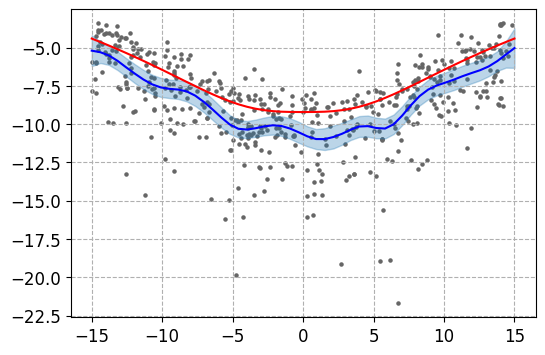

In [23]:
_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

ax.scatter(train_x, train_noise, marker='o', c='.4', s=5)
ax.plot(x_test, np.log(gene.noise(x_test)), c='r')
ax.plot(x_test, obs_test.mean, c='b')
ax.fill_between(
    x_test,
    lower.numpy(),
    upper.numpy(),
    color='tab:blue',
    alpha=.3, 
)

/tmp/ipykernel_11571/803921568.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax.scatter(train_x, np.exp(train_noise)**.5, marker='o', c='.4', s=5)
/tmp/ipykernel_11571/803921568.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax.plot(x_test, np.exp(obs_test.mean)**.5, c='b')


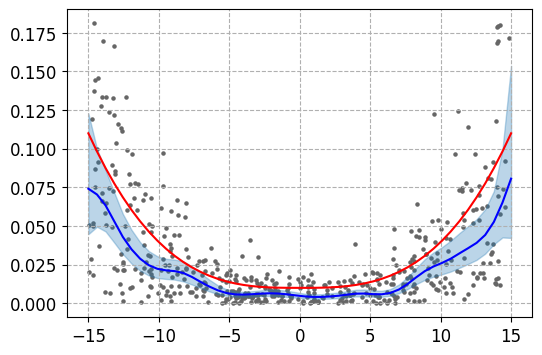

In [24]:
_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')



ax.scatter(train_x, np.exp(train_noise)**.5, marker='o', c='.4', s=5)
ax.plot(x_test, gene.noise(x_test)**.5, c='r')
ax.plot(x_test, np.exp(obs_test.mean)**.5, c='b')
ax.fill_between(
    x_test,
    torch.exp(lower).pow(.5).numpy(),
    torch.exp(upper).pow(.5).numpy(),
    color='tab:blue',
    alpha=.3, 
)

## Fit the complete model

### Setup the model

In [25]:
from gpytorch.constraints import Positive
from gpytorch.likelihoods import (
    GaussianLikelihood,
    LikelihoodList
)
from gpytorch.likelihoods.noise_models import HeteroskedasticNoise
from gpytorch.models import IndependentModelList


from gp_sand.heteroscedastic import (
    HeteroskedasticGP,
    HeteroskedasticGaussianLikelihood,
    NoiseGP
)

# Create the noise model
noise_likelihood = GaussianLikelihood()
# noise_likelihood.noise = .5

noise_constraint = Positive()
noise_gp = NoiseGP(
    train_x=train_x,
    train_y=noise_constraint.inverse_transform(
        torch.ones_like(train_y) * 1e-2
    ),
    likelihood=noise_likelihood
)

# Over arching GP
noise_covar = HeteroskedasticNoise(
    noise_model=noise_gp,
    noise_constraint=noise_constraint,
)
hetero_likelihood = HeteroskedasticGaussianLikelihood(noise_covar)
# hetero_likelihood = 
hetero_gp = HeteroskedasticGP(
    train_x=train_x,
    train_y=train_y,
    likelihood=hetero_likelihood
)

# model = IndependentModelList(noise_gp, hetero_gp)
# likelihood = LikelihoodList(noise_gp.likelihood, hetero_gp.likelihood)

In [26]:
from gpytorch.mlls import ExactMarginalLogLikelihood

training_iter = 1000

# Set training mode
noise_gp.train()
noise_likelihood.train()
hetero_gp.train()
# hetero_likelihood.train()


# Loss and optimzer
mll_noise = ExactMarginalLogLikelihood(noise_likelihood, noise_gp)
mll_hetero = ExactMarginalLogLikelihood(hetero_likelihood, hetero_gp)

# optimizer = torch.optim.Adam(
#     [
#         {'params': noise_gp.parameters()},
#         {'params': hetero_gp.parameters()},
#     ],
#     lr=0.1,
# )

optim_hetero = torch.optim.Adam(hetero_gp.parameters(), lr=0.1)
optim_noise = torch.optim.Adam(noise_gp.parameters(), lr=0.0001)

noise_loss = np.array([0])
for i in range(training_iter):
    # Zero grad sa face
    # optimizer.zero_grad()
    optim_hetero.zero_grad()
    optim_noise.zero_grad()

    # Pred for the heteroskedastic model
    hetero_pred = hetero_gp(train_x)
    hetero_loss = -mll_hetero(hetero_pred, train_y, train_x)
    hetero_loss.backward()
    optim_hetero.step()

    if i == 200:
        optim_noise.lr = 0.1

    # Pred for noise
    if (i >= 50):
        if i % 10 == 0:
            with torch.no_grad():
                res = (hetero_pred.mean - train_y).pow(2)
                res = noise_constraint.inverse_transform(res)
        
        noise_gp.set_train_data(train_x, res, strict=False)
        noise_pred = noise_gp(train_x)
        noise_loss = -mll_noise(noise_pred, res)
        
        noise_loss.backward()
        optim_noise.step()
    
    # optimizer.step()



    # Logger:
    if (i + 1) % 50 == 0:
        msg = f'Iter {i + 1} of {training_iter}: ' \
              f'Loss (main): {hetero_loss.item():.3f},\t'  \
              f'Loss (latent): {noise_loss.item():.3f},\t'  # \
            #   f'Lengthscale: {model.covar_module.base_kernel.lengthscale.item():.3f},\t' \
            #   f'Noise: {model.likelihood.noise.item():.3f}' 
        logger.info(msg)

04:28:40 INFO: Iter 50 of 1000: Loss (main): -1.241,	Loss (latent): 0.000,	
04:28:41 INFO: Iter 100 of 1000: Loss (main): -1.658,	Loss (latent): 2.924,	
04:28:42 INFO: Iter 150 of 1000: Loss (main): -1.957,	Loss (latent): 2.896,	
04:28:43 INFO: Iter 200 of 1000: Loss (main): -1.971,	Loss (latent): 3.105,	
04:28:44 INFO: Iter 250 of 1000: Loss (main): -1.990,	Loss (latent): 3.545,	
04:28:45 INFO: Iter 300 of 1000: Loss (main): -2.003,	Loss (latent): 3.998,	
04:28:46 INFO: Iter 350 of 1000: Loss (main): -2.009,	Loss (latent): 4.382,	
04:28:47 INFO: Iter 400 of 1000: Loss (main): -2.015,	Loss (latent): 4.881,	
04:28:48 INFO: Iter 450 of 1000: Loss (main): -2.006,	Loss (latent): 4.932,	
04:28:49 INFO: Iter 500 of 1000: Loss (main): -2.004,	Loss (latent): 5.359,	
04:28:50 INFO: Iter 550 of 1000: Loss (main): -2.005,	Loss (latent): 5.463,	
04:28:51 INFO: Iter 600 of 1000: Loss (main): -1.994,	Loss (latent): 5.592,	
04:28:52 INFO: Iter 650 of 1000: Loss (main): -1.988,	Loss (latent): 5.892,	


In [27]:
noise_likelihood.eval()
noise_gp.eval()
hetero_gp.eval()
hetero_likelihood.eval()

test_x = torch.linspace(-15, 15, 201)
test_y = gene.true_signal(test_x)
test_var = gene.noise(test_x)

with torch.no_grad():
    # test_x = torch.linspace(0, 1, 201)
    # test_y = torch.cos(test_x * 2 * math.pi)
    

    f_test = hetero_gp(test_x)
    obs_test = hetero_likelihood(f_test, test_x)

    fn_test = noise_gp(test_x)
    # res = (test_y - f_test.mean)**2
    # res = torch.log((test_y - f_test.mean)**2)

    lower, upper = obs_test.confidence_region()

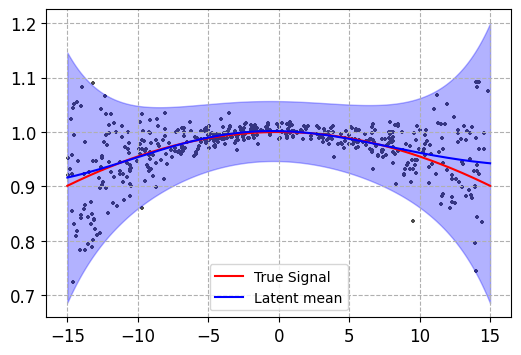

In [28]:
_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')


ax.scatter(train_x.numpy(), train_y.numpy(), s=5, marker='+', c='.3', zorder=1)
ax.plot(test_x, test_y, c='r', label='True Signal')
ax.plot(test_x, obs_test.mean, c='b', label='Latent mean')

ax.fill_between(
    test_x.numpy(),
    lower.numpy(),
    upper.numpy(),
    color='b',
    alpha=.3, 
)
ax.legend()

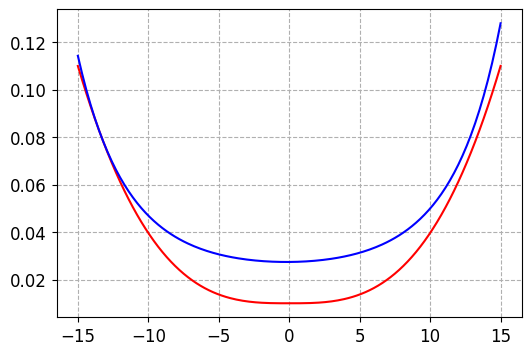

In [29]:
_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')


ax.plot(test_x, test_var**.5, c='r', label='True Variance')

ax.plot(
    test_x,
    noise_constraint.transform(fn_test.mean)**.5,
    c='b'
)

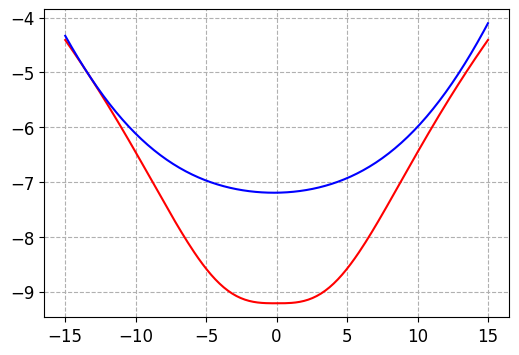

In [30]:
_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')


ax.plot(test_x, noise_constraint.inverse_transform(test_var), c='r', label='True Variance')

ax.plot(
    test_x,
    fn_test.mean,
    c='b'
)